<div style="text-align: center;">
    <img src="./img/2.png" alt="Image 2">
</div>

# **From What You Say to Where You Stay : Designing Interior Spaces with AI**

<div style="text-align: center;">
    <img src="./img/1.jpg" alt="Image 1">
    <br>
    <i>AHMED Ayan, AHMED Rayyan, GONCHAROV Gleb, HEZBRI Nour, KUMAR Akshita</i>
</div>

## Introduction

 The challenge we propose consists in *generating room designs based on text descriptions*. The goal then is to create a model that can generate an image of a room that matches the description provided in text. This could be particularly valuable for interior designers, who can use such a model to visualize a room just from a description. Depending on the specificity of the text, we expect the model to either follow precise details or take creative liberties in generating the type of room featured—for instance, if the text does not provide any hints about it.  

 The data for this challenge is public and comes from a 2024 released paper (https://arxiv.org/abs/2407.05980) of Kassab et al. , which provides a rich dataset for Multi-Modal Interior Scene (MMIS) generation. Each image in the dataset is accompanied by a textual description and an audio recording, offering multiple sources of information for scene generation and recognition. The dataset covers a wide range of interior styles, layouts, and furnishings, capturing various design aesthetics. For this challenge, we've focused simply on images and textual descriptions of four specific interior styles: *Art-Deco, Coastal, Rustic, and Traditional, which we reorganized appropriately for our needs. After filtering out images without corresponding textual captions, the final dataset we use here includes **11,702 images for training, 1,655 for the public test set, and 1,656 for the private test set*. 

This task is particularly important in real-life applications such as *interior design and home planning*, where customers often formulate their design ideas through textual descriptions. By turning these descriptions into visual representations, we particularly simplify the room design process, promote diversity in design choices, and save time.

## Data Exploration

The dataset is organized into three subsets: **training**, **validation**, and **private test** data, comprising **11,702** training samples, **1,655** validation samples, and **1,656** samples in the private test set. Each subset is structured into directories that not only contain the room images but also a corresponding `captions.txt` file, which holds the descriptions of the rooms in that particular subset.

The `captions.txt` file is formatted in a way where each room description is directly associated with its corresponding image file. Descriptions are followed by a specially formatted line that provides the image file path in the format: 

```
##### Room_Type/Room_Number.jpg ######
```

For example, a **bedroom** with the unique room number **6601** in the **training** set would be stored as an image file at `"train/Bedroom/6601.jpg"`, with its description present in the `"train/captions.txt"` file. By systematically reading the descriptions line by line and parsing this pattern, we can efficiently map each description to its image file path using preprocessing techniques.

The dataset includes **five room types**:
- **Bedroom**
- **Bathroom**
- **Living Room**
- **Dining Room**
- **Kitchen**

A key feature of this dataset is the uniqueness of room numbers across all subsets and room types. This design ensures that if a specific room number (e.g., **6601**) is present in the **Bedroom** category, it will not appear in any other room type or dataset partition. This avoids any overlap and potential data leakage, enhancing the reliability of model training and evaluation.

The clear organization of the dataset, coupled with the unique room identifiers and systematic formatting of the descriptions, allows for efficient preprocessing and robust data pipeline construction. This structure is particularly beneficial for tasks that require both **image processing** and **natural language understanding**, as it ensures consistent pairing between visual and textual data.

### Requirements

In [1]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from wordcloud import WordCloud
from sklearn.cluster import KMeans
import torch
from sentence_transformers import SentenceTransformer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

### Defining a class to Display the Data

In [2]:
# Define the dataset class
class RoomDataset(Dataset):
    def __init__(self, text_file, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.data = []

        # Read the text file to link descriptions with images
        with open(text_file, 'r') as f:
            description = ""
            for line in f:
                line = line.strip()  # Remove leading/trailing whitespace

                # If '#####' is found, we know that the line contains an image reference
                if '#####' in line:
                    # Split only on the first occurrence of '#####'
                    parts = line.split('#####', 1)
                    description = parts[0].strip()  # Get the description part
                    image_ref = parts[1].strip()  # Get the image reference part

                    # Remove the trailing '######' from the image reference
                    if image_ref.endswith('######'):
                        image_ref = image_ref[:-6].strip()

                    # Process the image reference
                    parts = image_ref.strip().split("\\")
                    room_type = parts[0]  # Bathroom/Kitchen/...
                    image_number = parts[1].replace('.jpg', '')  # Remove the .jpg extension

                    # Construct the full image path
                    image_filename = f"{image_number}.jpg"
                    image_path = os.path.join(self.image_dir, room_type, image_filename)

                    # Check if the image exists
                    if not os.path.exists(image_path):
                        print(f"Warning: Image '{image_filename}' not found. Skipping description.","The Room Type was",room_type)
                        continue  # Skip this entry if image is not found

                    # Add the description and image path to the dataset
                    self.data.append((description, image_path))

        # If the last description does not end with a proper '#####', ensure it's handled
        if not line.endswith('#####'):
            print("Warning: Last description is not followed by '#####', but it will be linked correctly.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        description, image_path = self.data[idx]

        # Load and transform the image
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return description, image

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


In [3]:
image_directory = r"./data/public/train"  # The base directory where your images are stored
text_file_path = r"./data/public/train/captions.txt"  # The path to your text file with descriptions and image paths

image_directory_val = r"./data/public/test" # The base directory where your images are stored
text_file_path_val = r"./data/public/test/captions.txt"

# image_directory_test = r"D:\Users_ayra\Desktop\M2_Data_Science\DataCamp\data\Test_Data" # The base directory where your images are stored
# text_file_path_test = r"D:\Users_ayra\Desktop\M2_Data_Science\DataCamp\data\Test_Data\captions.txt"



# Initialize the dataset and dataloader
dataset = RoomDataset(text_file=text_file_path, image_dir=image_directory, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

dataset_val = RoomDataset(text_file=text_file_path_val, image_dir=image_directory_val, transform=transform)
dataloader_val = DataLoader(dataset_val, batch_size=64, shuffle=True)

# dataset_test = RoomDataset(text_file=text_file_path_test, image_dir=image_directory_test, transform=transform)
# dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=True)

In [5]:
print("Size of Dataloader:",len(dataloader))
print("Number of Training Samples:",len(dataset.data))
# print("Number of Test Samples:",len(dataset_test.data))
print("Number of Validation Samples:",len(dataset_val.data))
import random

Size of Dataloader: 175
Number of Training Samples: 11172
Number of Validation Samples: 1655


### Images with their Corresponding Descriptions

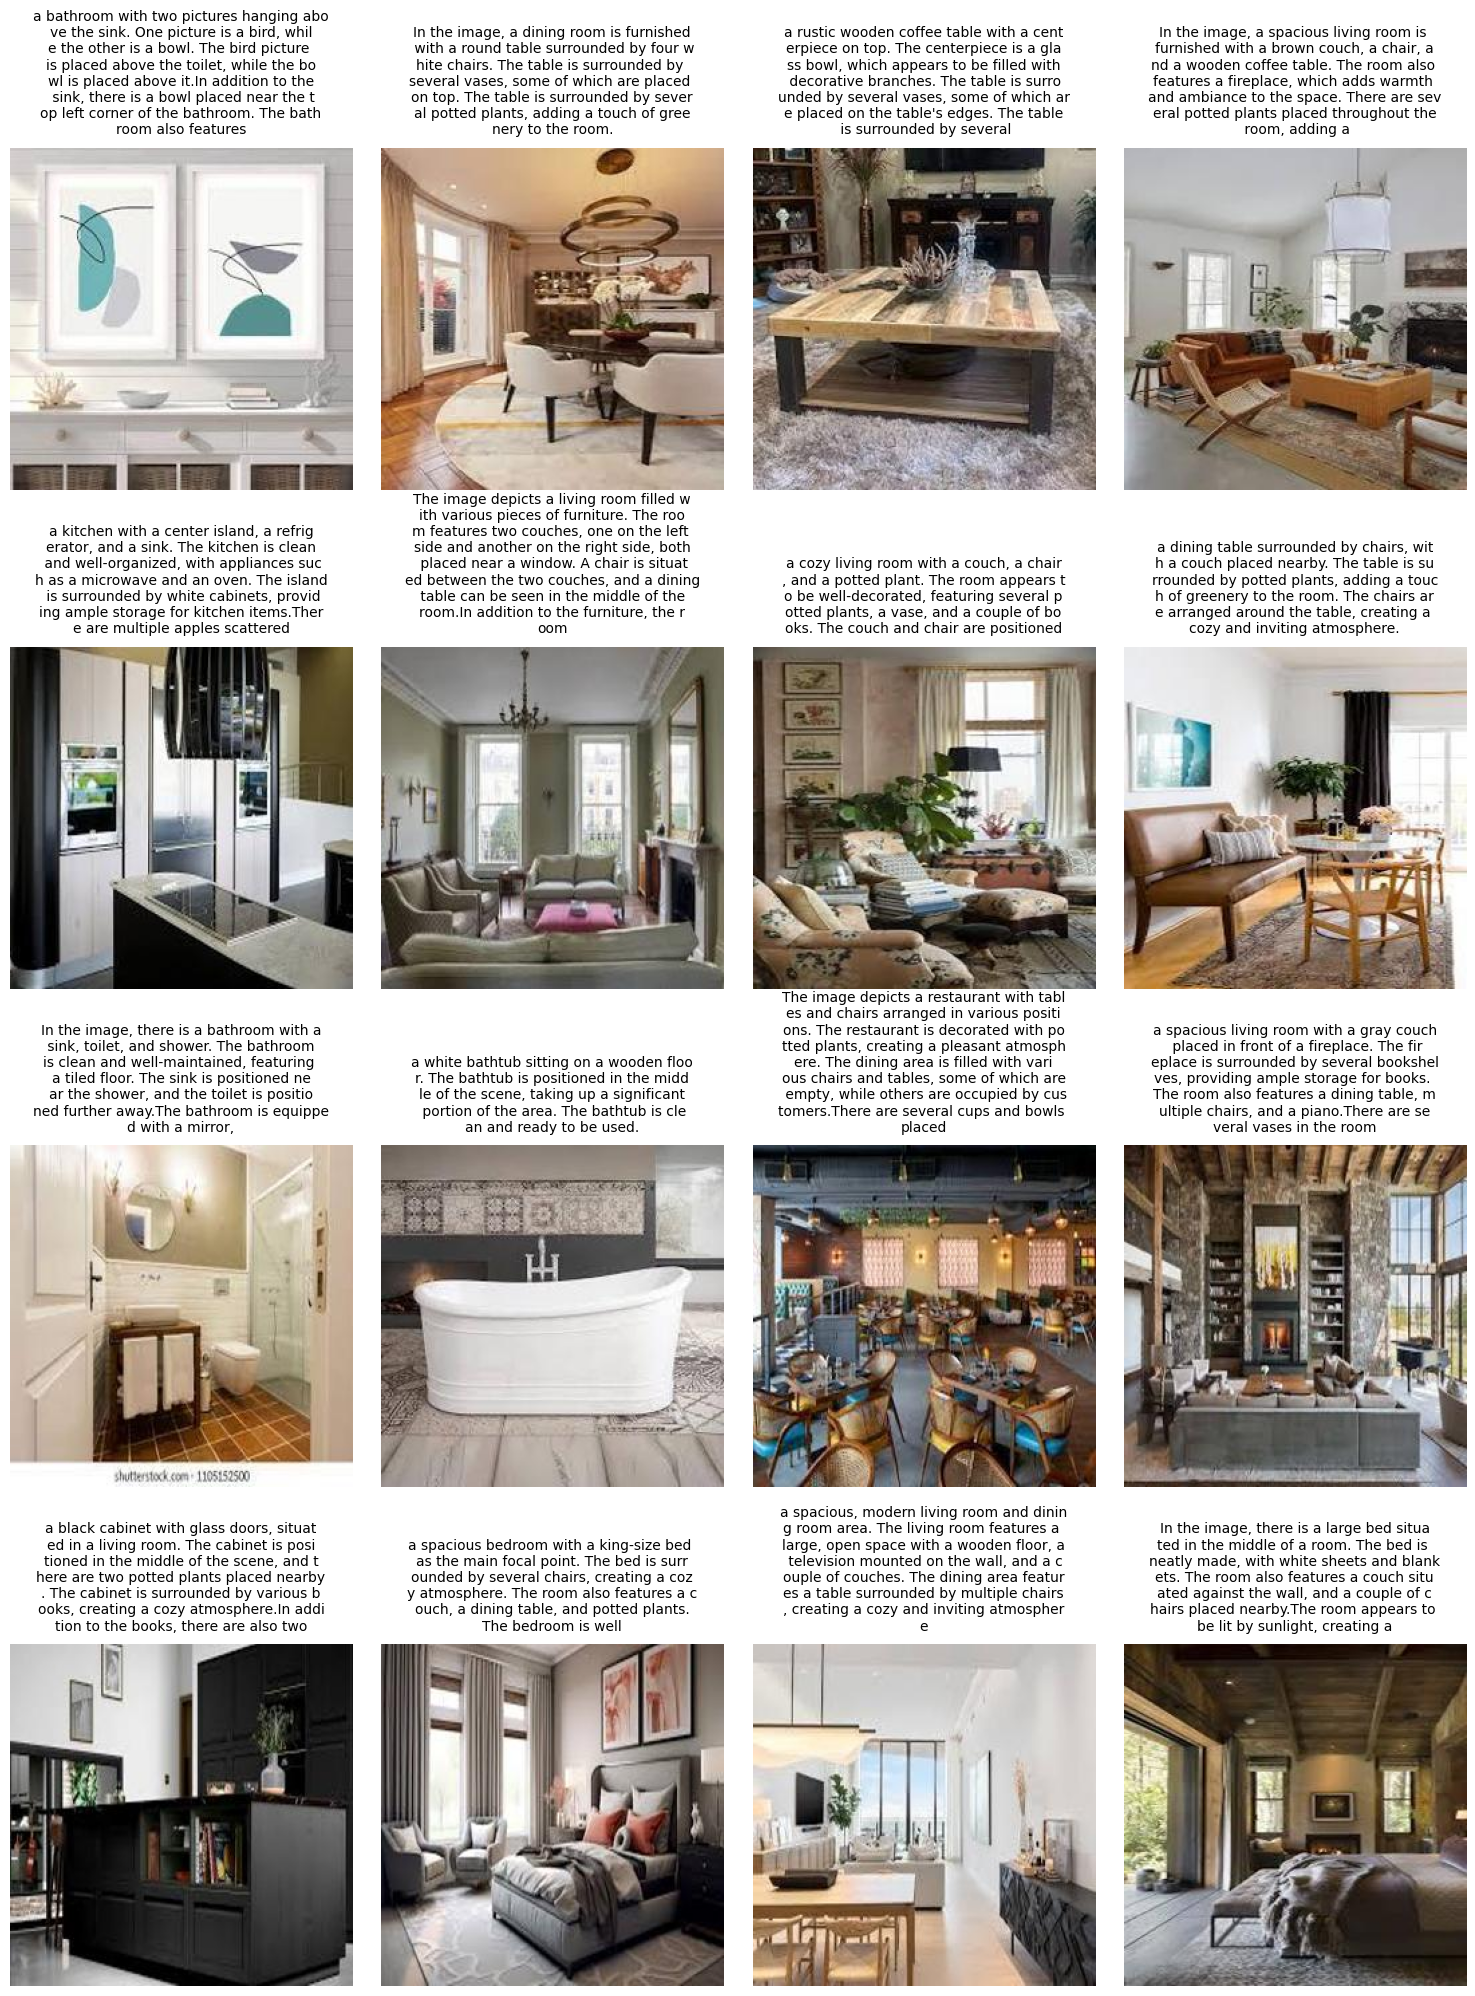

In [6]:
grid_size = 4
random_samples = random.sample(dataset.data, grid_size * grid_size)


fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 20))
plt.subplots_adjust(hspace=0.6)  

for ax, (description, image_path) in zip(axes.flatten(), random_samples):
    image = Image.open(image_path)
    ax.imshow(image)
    ax.axis('off')
    
    wrapped_text = "\n".join([description[i:i+40] for i in range(0, len(description), 40)])
    ax.set_title(wrapped_text, fontsize=10, pad=10, loc='center')

plt.tight_layout()
plt.show()


## Exploratory Data Analysis (EDA)

### Room Type Distribution

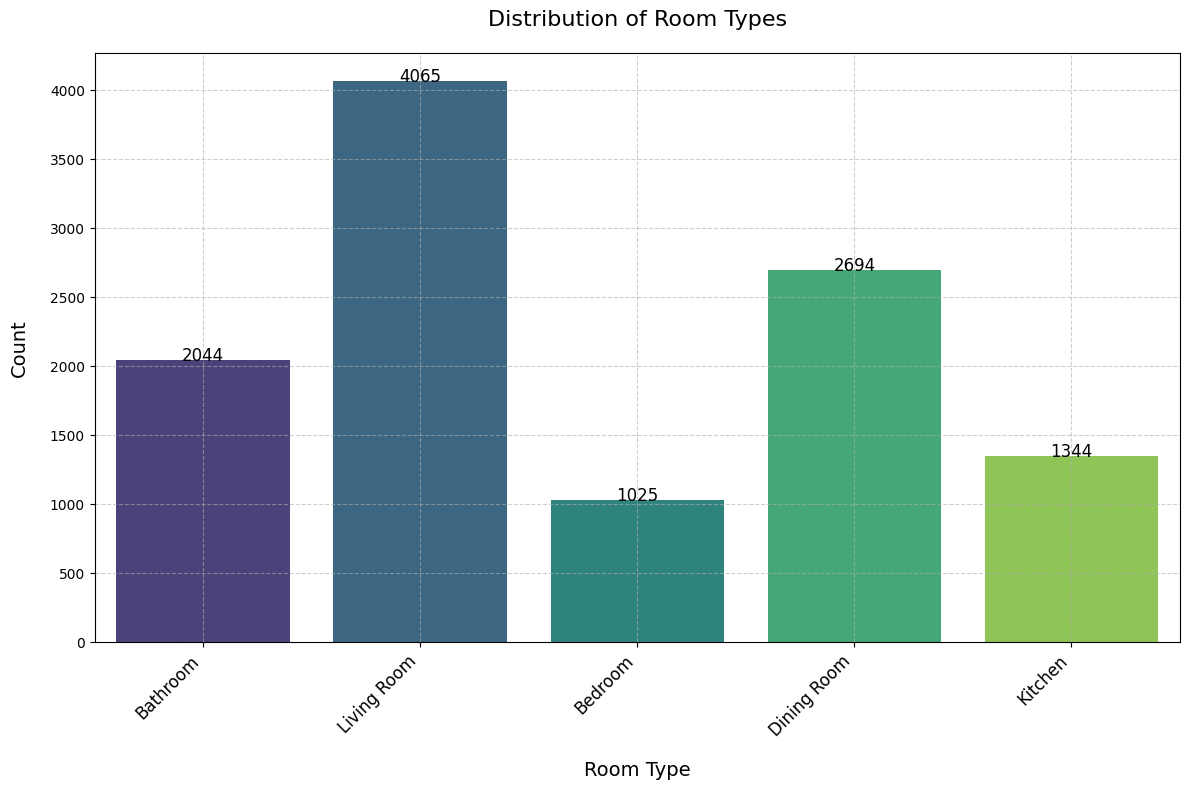

In [7]:
room_types = [os.path.basename(os.path.dirname(image_path)) for _, image_path in dataset.data]
room_type_counts = Counter(room_types)

room_type_labels, room_type_values = zip(*room_type_counts.items())

plt.figure(figsize=(12, 8))

sns.barplot(x=list(room_type_labels), y=list(room_type_values), palette="viridis")

plt.title("Distribution of Room Types", fontsize=16, pad=20)
plt.xlabel("Room Type", fontsize=14, labelpad=15)
plt.ylabel("Count", fontsize=14, labelpad=15)

plt.xticks(rotation=45, ha="right", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)

for index, value in enumerate(room_type_values):
    plt.text(index, value + 0.05, str(value), ha='center', fontsize=12, color='black')

plt.tight_layout()

plt.show()



The bar chart represents the distribution of different room types in the dataset. The highest frequency is observed for **Living Rooms (4065 instances)**, suggesting that this dataset has a strong representation of living spaces, which may be due to their central role in home design. **Dining Rooms (2694 instances)** and **Bathrooms (2044 instances)** follow in frequency, indicating significant presence but lower than living rooms. Bedrooms (1025) and Kitchens (1344) are the least represented, which might suggest either an imbalance in the dataset or a lesser focus on these spaces in the provided textual descriptions.

The variation in room type frequencies suggests that images and textual descriptions related to certain rooms (like Living Rooms) may have a greater impact on the generative model’s performance. This imbalance could lead to biased outputs if the model generates interior design images primarily based on the most frequent categories. Further dataset balancing or augmentation techniques might be necessary to ensure a more diverse representation of different room types.

### Checking for Missing Data

In [8]:
# Missing Data Analysis (Check for missing images)
missing_images = []
for description, image_path in dataset.data:
    if not os.path.exists(image_path):
        missing_images.append((description, image_path))

if missing_images:
    print(f"Warning: {len(missing_images)} missing images!")
    for description, image_path in missing_images[:5]:  # Show the first 5 missing image entries
        print(f"Description: {description}")
        print(f"Missing Image Path: {image_path}")
else:
    print("No missing images in the dataset.")

No missing images in the dataset.


In [9]:
description_lengths = [len(description.split()) for description, _ in dataset.data]

# Additional Info: Dataset Summary
print(f"Number of Room Types: {len(room_type_counts)}")
print(f"Total Number of Samples in Dataset: {len(dataset.data)}")
print(f"Average Description Length: {np.mean(description_lengths):.2f} words")

Number of Room Types: 5
Total Number of Samples in Dataset: 11172
Average Description Length: 46.81 words


### Distribution of Description Lengths

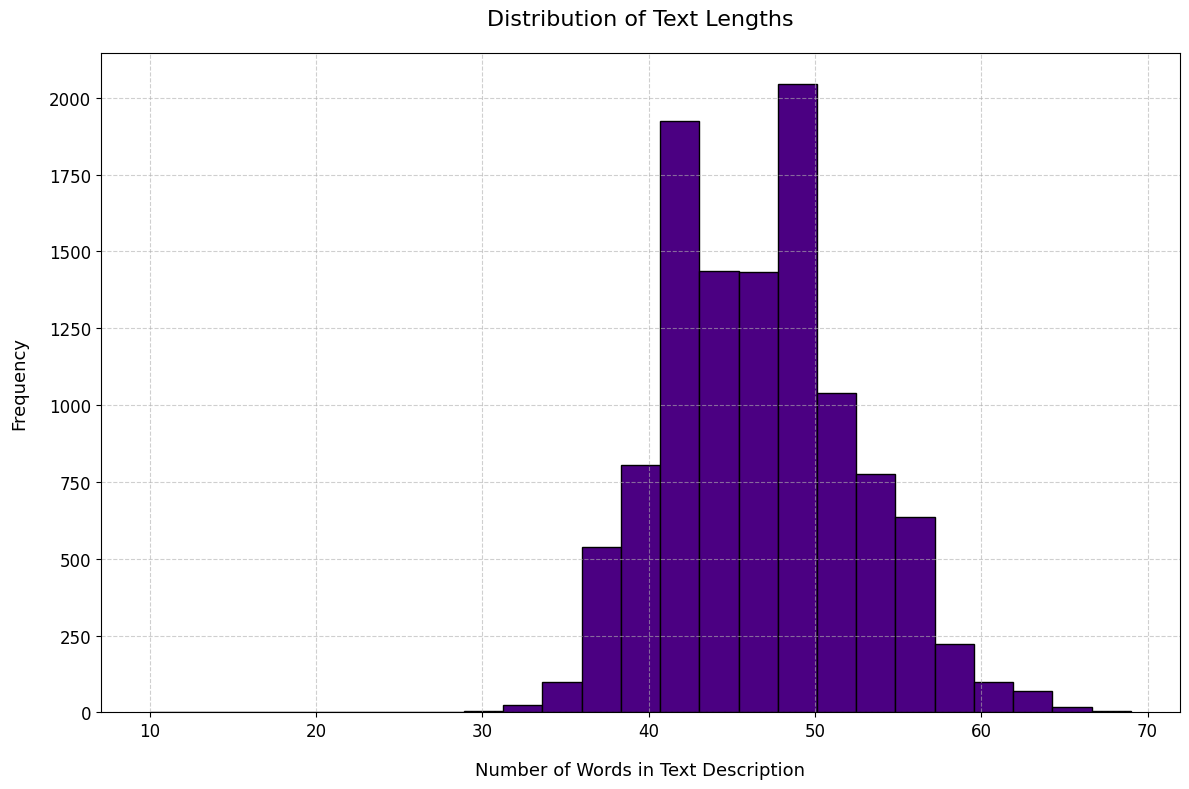

In [10]:
all_descriptions = [desc for desc, _ in dataset.data]
text_lengths = [len(desc.split()) for desc in all_descriptions]

plt.figure(figsize=(12, 8))

plt.hist(text_lengths, bins=25, color='indigo', edgecolor='black')

plt.xlabel('Number of Words in Text Description', fontsize=13, labelpad=15)
plt.ylabel('Frequency', fontsize=13, labelpad=15)
plt.title('Distribution of Text Lengths', fontsize=16, pad=20)

plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()



The histogram displays the distribution of the number of words in text descriptions used for generating interior design images. The majority of the text descriptions range between 35 and 55 words, with peaks around 45-50 words. This indicates that most descriptions tend to be of similar length, which may suggest a standardized format in the dataset. The presence of two noticeable peaks suggests potential bimodality, meaning there could be two different categories of text prompts, such as short and detailed descriptions.

Understanding this distribution is crucial for conditional image generation because text length can influence the level of detail in generated images. If descriptions are too short, they may not provide enough information for diverse interior designs, while overly long descriptions might introduce unnecessary complexity. Ensuring a balanced dataset with a variety of text lengths could help improve the model’s ability to generalize and create diverse designs.


### Word Cloud of Text Descriptions

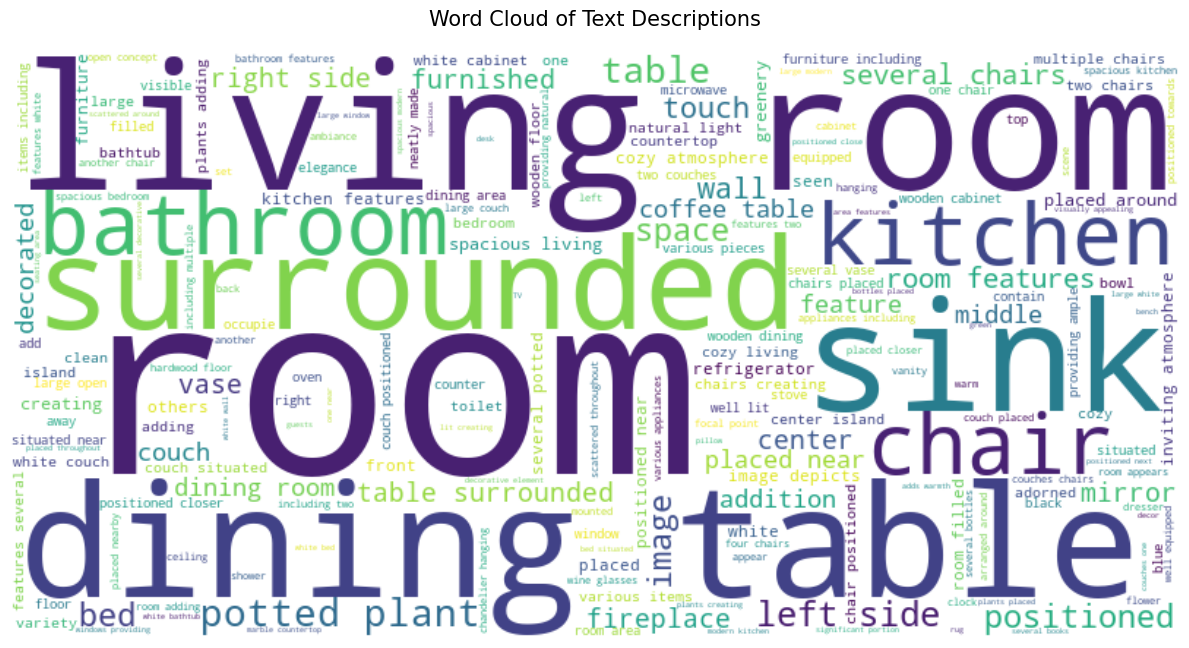

In [11]:
all_text = " ".join(all_descriptions)

wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis', 
    contour_color='black', 
    contour_width=2, 
    max_words=200, 
    stopwords=None, 
    random_state=42
).generate(all_text)

plt.figure(figsize=(12, 8))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.title('Word Cloud of Text Descriptions', fontsize=15, pad=20)

plt.tight_layout()
plt.show()



The word cloud visualizes the most frequently occurring words in the textual descriptions related to interior design images. The most prominent words, such as **"room," "living," "dining," "surrounded," and "sink,"** indicate a focus on spatial relationships and key furniture pieces. The frequent appearance of words like **"table," "chair," "couch," and "mirror"** suggests that furniture and decor elements play a crucial role in the dataset’s descriptions.

Additionally, words like **"decorated," "potted," "feature," "touch," and "ambiance"** suggest that aesthetic details and room atmosphere are well-documented in the descriptions. This richness in descriptive elements could enhance the conditional image generation process, allowing the model to capture intricate design nuances. However, there could be biases in the dataset if certain design elements (e.g., sinks and tables) appear more frequently, potentially limiting the diversity of generated designs.

### Display Dominant Colors of Some Sample Images

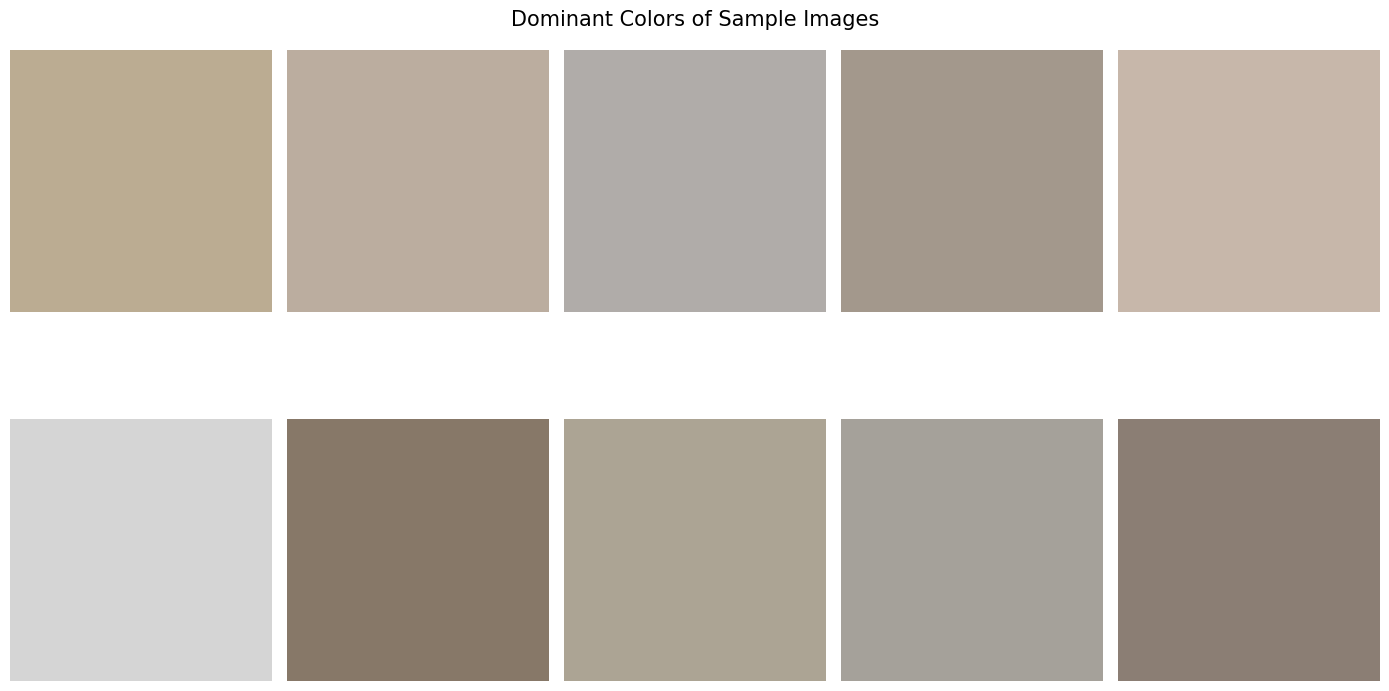

In [12]:
def dominant_color(image_path, n_colors=1):
    image = Image.open(image_path)
    image = image.resize((image.width // 5, image.height // 5))
    image = np.array(image)
    image = image.reshape((-1, 3))

    kmeans = KMeans(n_clusters=n_colors, random_state=42).fit(image)
    return kmeans.cluster_centers_.astype(int)

sample_image_paths = [image_path for _, image_path in random.sample(dataset.data, 10)]
colors = [dominant_color(image_path)[0] for image_path in sample_image_paths]

plt.figure(figsize=(14, 8))
for i, color in enumerate(colors):
    plt.subplot(2, 5, i+1)
    plt.imshow([[color]])
    plt.axis("off")
    plt.gca().set_facecolor('white')

plt.suptitle('Dominant Colors of Sample Images', fontsize=15)
plt.tight_layout()
plt.subplots_adjust(top=1.05)
plt.show()


The dominant colors in the dataset's sample images primarily consist of neutral tones such as shades of brown, gray, and beige. These colors are commonly associated with modern and minimalist interior designs, indicating that the dataset likely consists of such styles. The presence of muted tones rather than vibrant colors suggests that most designs emphasize a sophisticated, earthy aesthetic rather than bold or eclectic interiors.

The dominance of neutral shades in the dataset may influence the model’s generated images by making it biased toward these colors. If the dataset lacks diverse color palettes, the model might struggle to generate vibrant or unconventional interior designs. To address this, additional data augmentation or fine-tuning with more colorful interiors could enhance the model’s ability to create varied and dynamic designs.

### Roomtype vs Description Length

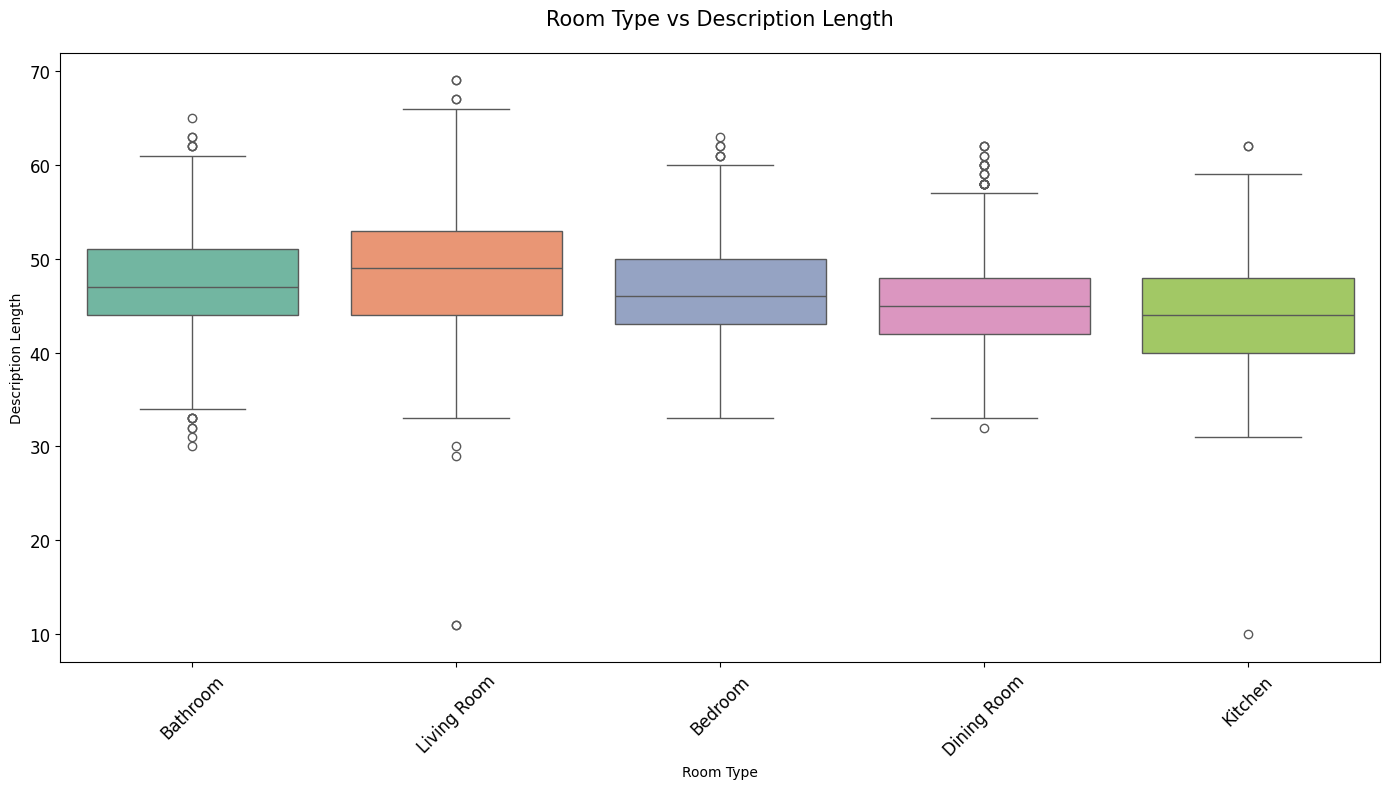

In [13]:
room_type_lengths = {}

for description, image_path in dataset.data:
    room_type = os.path.basename(os.path.dirname(image_path))
    length = len(description.split())
    if room_type not in room_type_lengths:
        room_type_lengths[room_type] = []
    room_type_lengths[room_type].append(length)

max_length = max(len(lengths) for lengths in room_type_lengths.values())

for room_type in room_type_lengths:
    room_type_lengths[room_type] += [np.nan] * (max_length - len(room_type_lengths[room_type]))

room_type_lengths_df = pd.DataFrame(room_type_lengths)
room_type_lengths_df = room_type_lengths_df.melt(var_name="Room Type", value_name="Description Length")

plt.figure(figsize=(14, 8))
sns.boxplot(x="Room Type", y="Description Length", data=room_type_lengths_df, palette="Set2")
plt.title("Room Type vs Description Length", fontsize=15, pad=20)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


## Model Setup

The `RoomDatasetCond` class is a pivotal component of our data pipeline, meticulously designed to streamline the extraction and processing of image-description pairs for our model. This class begins by parsing the `captions.txt` file, where each line contains a textual description of a room and a reference to its corresponding image. It intelligently locates the image file associated with each description by constructing the full path and verifying its existence within the specified directory. If an image is missing or inaccessible, the class is built to gracefully handle this scenario by skipping the entry, ensuring robustness in data loading.

Prior to this stage, we conducted thorough data cleaning, where all invalid or missing images were identified and removed. As a result, our current dataset (both for training and validation) is perfectly aligned, guaranteeing that every description listed in `captions.txt` has a valid and accessible image counterpart. This preemptive cleaning process significantly enhances the efficiency and reliability of the `RoomDatasetCond` class, eliminating unnecessary runtime errors and interruptions.

A key distinction between the `RoomDatasetCond` class and its predecessor, `RoomDataset`, lies in its advanced use of text embeddings. Instead of merely returning raw text descriptions, this class integrates an embedding model to convert each description into a high-dimensional numerical representation. Specifically, we utilize the **Nomic Embedding** model, which is based on the **Mixture of Experts (MoE)** architecture.[https://www.nomic.ai/blog/posts/nomic-embed-text-v1]

For each room description, the embedding model generates a **768-dimensional vector**, capturing nuanced semantic and contextual information from the text. This embedding process is crucial as it translates human-readable descriptions into a format that can be effectively consumed by downstream machine learning models, especially those leveraging high-dimensional feature spaces. The rich, dense vector representations provided by Nomic Embedding empower the model to draw deeper connections between textual and visual data, ultimately contributing to superior model performance and more accurate image reconstructions.


The base model we propose for this task is a **Conditional Variational Autoencoder (Conditional VAE)**, which is a generative model that extends the standard VAE by incorporating additional conditional information. This architecture is particularly useful when generating images conditioned on specific features, such as textual descriptions.

### **1. Data Preparation and Transformation**
We begin by defining a `RoomDatasetCond` class, which processes image-description pairs. The dataset utilizes a `torchvision` transform pipeline that:
- **Resizes** images to a fixed size of `(128, 128)` pixels.
- **Converts** images to tensors suitable for input to the neural network.

The data is loaded into PyTorch `DataLoader` objects for both training and validation, with a batch size of 64 and shuffling enabled to ensure a well-mixed batch of samples during training.


### **2. Model Architecture**
The Conditional VAE consists of three main components:
1. **Encoder**
2. **Decoder**
3. **Reparameterization Trick**


### Dataset/Dataloader Creation

In [6]:
class RoomDatasetCond(Dataset):
    def __init__(self, text_file, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.data = []
        self.model = SentenceTransformer("nomic-ai/nomic-embed-text-v1", trust_remote_code=True)
        if not hasattr(self.model, "output_dim"):
            self.model.output_dim = 768  # adjust as needed

        # Read the text file to link descriptions with images
        with open(text_file, 'r') as f:
            description = ""
            for i, line in enumerate(f):
                line = line.strip()  # Remove leading/trailing whitespace

                # If '#####' is found, we know that the line contains an image reference
                if '#####' in line:
                    # Split only on the first occurrence of '#####'
                    parts = line.split('#####', 1)
                    description = parts[0].strip()  # Get the description part
                    image_ref = parts[1].strip()  # Get the image reference part

                    # Remove the trailing '######' from the image reference
                    if image_ref.endswith('######'):
                        image_ref = image_ref[:-6].strip()

                    # Process the image reference
                    parts = image_ref.strip().split("\\")
                    room_type = parts[0]  # Bathroom/Kitchen/...
                    image_number = parts[1].replace('.jpg', '')  # Remove the .jpg extension

                    # Construct the full image path
                    image_filename = f"{image_number}.jpg"
                    image_path = os.path.join(self.image_dir, room_type, image_filename)

                    # Check if the image exists
                    if not os.path.exists(image_path):
                        print(f"Warning: Image '{image_filename}' not found. Skipping description.","The Room Type was",room_type)
                        continue  # Skip this entry if image is not found

                    # Add the description and image path to the dataset
                    text_embedding = self.get_text_embedding(description)  # Get text embedding
                    self.data.append((text_embedding, image_path))

        # If the last description does not end with a proper '#####', ensure it's handled
        if not line.endswith('#####'):
            print("Warning: Last description is not followed by '#####', but it will be linked correctly.")

    def get_text_embedding(self, text):
        with torch.no_grad():
            outputs = self.model.encode(text)
        return outputs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text_embedding, image_path = self.data[idx]

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return text_embedding, image


In [7]:
%%time
transform = transforms.Compose([
    transforms.Resize((128, 128)), # Resize image to a fixed size
    transforms.ToTensor(),          # Convert to tensor
])
dataset = RoomDatasetCond(text_file=text_file_path, image_dir=image_directory, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

dataset_val = RoomDatasetCond(text_file=text_file_path_val, image_dir=image_directory_val, transform=transform)
dataloader_val = DataLoader(dataset_val, batch_size=64, shuffle=True)


!!!!!!!!!!!!megablocks not available, using torch.matmul instead
<All keys matched successfully>
<All keys matched successfully>


CPU times: total: 5min 15s
Wall time: 5min 38s


In [8]:
dataset[0][1].max()

tensor(1.)

### Encoder of VAE

The encoder is designed to compress input images into a lower-dimensional latent space, incorporating conditional text embeddings:
- **Conditioning Pathway:** 
  The textual descriptions are embedded into a 768-dimensional vector using a Mixture of Experts (MoE) model. An MLP processes these embeddings through several `LeakyReLU`-activated linear layers, enriching the conditioning features.
- **Image Encoding Pathway:** 
  The input images pass through a series of convolutional layers (`Conv2d`), each followed by `LeakyReLU` activations and dropout layers (`F.dropout`) with a dropout rate of 0.1 to mitigate overfitting. Adaptive average pooling (`AdaptiveAvgPool2d`) is applied to reduce the spatial dimensions to a 1x1 feature map.
- **Feature Fusion and Latent Vector Generation:**
  The flattened image features are concatenated with the conditioning features. Batch normalization (`BatchNorm1d`) ensures stable learning, and a fully connected layer projects this combined feature set into the **latent space**, producing a latent vector of a specified dimension.


In [9]:
class Encoder(nn.Module):
    def __init__(self, input_channels, hidden_dim, latent_dim, n_layers,condition_dim=768, dropout=0.3, new_dim=768):
        super(Encoder, self).__init__()
        self.dropout = 0.1

        # MLP to process conditioning information
        self.mlp = nn.Sequential(
            nn.Linear(condition_dim, new_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(new_dim, new_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(new_dim, new_dim),
            nn.LeakyReLU(0.2)
        )

        # Convolutional layers for image encoding
        self.convs = nn.ModuleList([
            nn.Conv2d(input_channels, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1)
        ])
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.bn = nn.BatchNorm1d(hidden_dim + new_dim)
        self.fc = nn.Linear(hidden_dim + new_dim, latent_dim)

    def forward(self, x, cond):
        # Process the conditioning information
        cond_feats = self.mlp(cond)

        # Pass the image through the convolutional layers
        for conv in self.convs:
            x = F.leaky_relu(conv(x), 0.2)
            x = F.dropout(x, self.dropout, training=self.training)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the pooled output (it's now (batch_size, hidden_dim, 1, 1))

        # Concatenate the conditioning features with the pooled image features
        x = torch.cat([x, cond_feats], dim=-1)

        # Batch normalization and projection to latent space
        x = self.bn(x)
        x = self.fc(x)

        return x


### Decoder of VAE

The decoder is responsible for reconstructing images from the latent space, conditioned on the input description:
- **Conditioning Pathway:** 
  Similar to the encoder, an MLP processes the conditioning embeddings.
- **Latent and Condition Fusion:** 
  The latent vector is concatenated with the processed conditioning embeddings. This fused vector passes through a series of MLP layers, gradually transforming it into a feature map suitable for image reconstruction.
- **Image Reconstruction:** 
  The feature map is reshaped to `(8, 8, hidden_dim)` and upsampled using transposed convolutional layers (`ConvTranspose2d`). The use of `ReLU` activations ensures non-linearity, while a final `Sigmoid` activation constrains the output pixel values between 0 and 1.



In [10]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, n_layers, output_channels, cond_dim=768, new_dim=768):
        super(Decoder, self).__init__()
        self.n_layers = n_layers

        # MLP to process conditioning information
        self.mlpf = nn.Sequential(
            nn.Linear(cond_dim, new_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(new_dim, new_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(new_dim, new_dim),
            nn.LeakyReLU(0.2)
        )

        # MLP layers to decode latent + condition into a feature map
        mlp_layers = [nn.Linear(latent_dim + new_dim, hidden_dim)]
        mlp_layers += [nn.Linear(hidden_dim, hidden_dim) for _ in range(n_layers - 2)]
        mlp_layers.append(nn.Linear(hidden_dim, 8 * 8 * hidden_dim))  # Target shape before upsampling
        self.mlp = nn.ModuleList(mlp_layers)

        self.relu = nn.ReLU()


        # Transposed convolutional layers for upsampling

        self.deconvs = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, output_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # To ensure pixel values are in the range [0, 1]
        )

    def forward(self, x, cond):
        # Process conditioning information
        cond = self.mlpf(cond)

        # Concatenate latent vector with conditioned features
        x = torch.cat([x, cond], dim=-1)

        # Pass through MLP layers
        for i in range(self.n_layers - 1):
            x = self.relu(self.mlp[i](x))

        x = self.mlp[self.n_layers - 1](x)
        # Reshape to feature map suitable for transposed convolutions
        x = x.view(x.size(0), -1, 8, 8)  
        # Upsample to reconstruct the image
        x = self.deconvs(x)
        return x


### Conditional VAE

#### **Reparameterization Trick**
In the latent space, the model generates a mean (`mu`) and a log variance (`logvar`). During training, we sample from this distribution using:
$$
z = \mu + \epsilon \cdot \sigma
$$
where $\epsilon$ is a random noise sampled from a standard normal distribution, and $\sigma = \exp(0.5 \cdot \text{logvar})$. This trick allows for gradient-based optimization of the latent distribution.


#### **Loss Function**
The loss function is a combination of:
- **Reconstruction Loss:** 
  Mean Squared Error (MSE) between the original and reconstructed images. It ensures that the generated images are visually similar to the input.
$$
\text{Reconstruction Loss} = \text{MSE}(recon\_x, x)
$$
- **KL-Divergence Loss:** 
  Kullback-Leibler (KL) divergence between the latent distribution and a standard normal distribution. It regularizes the latent space by encouraging a Gaussian distribution.
$$
\text{KLD Loss} = -0.5 \cdot \sum(1 + \text{logvar} - \mu^2 - \exp(\text{logvar}))
$$
- **Total Loss:** 
  A weighted sum of the reconstruction and KL-divergence losses using a hyperparameter `beta` (set to 0.01). The `beta` controls the trade-off between reconstruction accuracy and the regularity of the latent space.
$$
\text{Total Loss} = \text{Reconstruction Loss} + \beta \cdot \text{KLD Loss}
$$


#### **Conditional VAE Workflow**
1. **Encoding:** 
   The input image and its corresponding description are passed through the encoder, generating `mu` and `logvar`.
2. **Sampling:** 
   The reparameterization trick samples a latent vector `z` from the learned distribution.
3. **Decoding:** 
   The latent vector `z` and the conditioned embedding are fed into the decoder to reconstruct the image.
4. **Loss Computation:** 
   The model calculates the reconstruction and KL-divergence losses and backpropagates the total loss.

In [11]:
# Conditional VAE Class
class ConditionalVAE(nn.Module):
    def __init__(self, input_channels=3, hidden_dim_enc=128, hidden_dim_dec=128,
                 latent_dim=128, n_layers_enc=4, n_layers_dec=4,
                 condition_dim=768, image_size=128, cond_new_dim=768):
        super(ConditionalVAE, self).__init__()

        # Initialize Encoder and Decoder
        self.encoder = Encoder(input_channels, hidden_dim_enc, latent_dim,
                               n_layers_enc, condition_dim, cond_new_dim)

        self.decoder = Decoder(latent_dim, hidden_dim_dec, n_layers_dec,
                               input_channels, condition_dim, cond_new_dim)

        # Layers to compute mu and logvar for latent space
        self.fc_mu = nn.Linear(latent_dim, latent_dim)
        self.fc_logvar = nn.Linear(latent_dim, latent_dim)

    def encode(self, x, c):
        # Encoding step to get latent features
        x_g = self.encoder(x, c)
        mu = self.fc_mu(x_g)
        logvar = self.fc_logvar(x_g)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick to sample from latent space
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z, c):
        # Decode latent vector to reconstruct the image
        return self.decoder(z, c)

    def forward(self, x, c):
        # Full forward pass through the VAE
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar

    def loss_function(self, recon_x, x, mu, logvar, beta=0.01):
        # Compute reconstruction and KL-divergence loss
        recon_loss = F.mse_loss(recon_x, x, reduction='mean')
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + beta * kld_loss
        return loss, recon_loss, kld_loss


## Model Training using Ramp Workflow

To efficiently manage the dataset, we utilized the `problem.get_train_data()` function, which automatically handles all necessary preprocessing and transformations. The function returns the training data in two components: `X` and `y`. Here, `y` contains the image tensors, while `X` holds the corresponding text embeddings derived from the image descriptions. This streamlined approach ensures that both the images and their associated text embeddings are consistently preprocessed and ready for model training.

For evaluation purposes, we followed a similar process for the test dataset. By using the `problem.get_test_data()` method, we obtained the test data, which we stored in `X_test` and `y_test`. Just like with the training set, `y_test` comprises the image tensors, and `X_test` contains the corresponding text embeddings. 

In [14]:
import problem

In [15]:
X, y = problem.get_train_data()

!!!!!!!!!!!!megablocks not available, using torch.matmul instead
<All keys matched successfully>


In [35]:
print(X.shape)
print(y.shape)

torch.Size([11172, 768])
torch.Size([11172, 3, 128, 128])


In [16]:
X_test, y_test = problem.get_test_data()

<All keys matched successfully>


In [36]:
print(X_test.shape)
print(y_test.shape)

torch.Size([1655, 768])
torch.Size([1655, 3, 128, 128])


We convert our data into tensors for RAMP compatibility and create a dataloader thereafter to be used in the model for training.

In [17]:
#convert to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [18]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

dataset = TensorDataset(X, y)

# Create DataLoader
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

To initialize our model, we created an instance of the `ConditionalVAE` class, which is part of the `CondImageGenerator` module in `submissions.starting_kit`. This class encapsulates the architecture and functionality of our conditional variational autoencoder (VAE) model. By utilizing this custom class, we ensure that the model is not only properly constructed but also seamlessly integrates the conditional image generation capabilities required for our task. 

Once the model is instantiated, we proceed to train it using the `.fit` method. This method handles the entire training process, including forward passes, backpropagation, and optimization. By leveraging the `.fit` method, we maintain a clean and modular approach to training, allowing us to easily manage epochs, monitor losses, and evaluate performance. 

In [25]:
from submissions.starting_kit import CondImageGenerator
model = CondImageGenerator.ConditionalVAE(input_channels=3, hidden_dim_enc=256, hidden_dim_dec=256,
                 latent_dim=256, n_layers_enc=5, n_layers_dec=5,
                 condition_dim=768, image_size=128, cond_new_dim=768, device='cuda')
model.fit(dataloader)

Epoch 1/1: 100%|██████████| 175/175 [19:44<00:00,  6.77s/it]

Loss: 0.3357


In [34]:
model

ConditionalVAE(
  (encoder): Encoder(
    (mlp): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=768, out_features=768, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=768, out_features=768, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
    )
    (convs): ModuleList(
      (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1-2): 2 x Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (global_pool): AdaptiveAvgPool2d(output_size=1)
    (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc): Linear(in_features=1024, out_features=256, bias=True)
  )
  (decoder): Decoder(
    (mlpf): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=768, out_features=768, bias=True

After completing the training process, we apply a similar workflow to the test set. We utilize the `.predict` method of our `ConditionalVAE` model to generate reconstructed images based on the test data. This method takes the input embeddings and produces corresponding reconstructed images, showcasing the model's ability to generalize to unseen data.

The reconstructed images obtained from the `.predict` method are then used for evaluation. We leverage the defined evaluation metrics, such as the CLIP Score and Fréchet Inception Distance (FID), to quantitatively assess the model's performance.

In [26]:
dataset_test = TensorDataset(X_test, y_test)

# Create DataLoader
batch_size = 64
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [27]:
result = model.predict(dataloader_test)

100%|██████████| 26/26 [01:21<00:00,  3.14s/it]


In [29]:
from ramp_custom.clip_score import CLIPScore
score_type = CLIPScore()
score = score_type(X_test, result)
print(score)

294.46665928629346


### Total Parameters

In [30]:
sum([p.numel() for p in model.encoder.parameters()])

4146432

## Results

To demonstrate the complete workflow of our model on RAMP, we initially trained the model for just a single epoch. This approach allowed us to illustrate how the training process works and how the model is saved automatically in the working directory. The model checkpoints are stored with a standardized naming convention as `'vae_epoch_{epoch_number}.pth'`, where `{epoch_number}` is replaced with the actual epoch count. This automated saving mechanism ensures that the model's state is preserved after each epoch, facilitating easier model management and reproducibility.

For a more comprehensive evaluation and to showcase the model's performance, we further trained the model for 400 epochs. This extended training period enabled the model to learn more complex patterns in the data and produce more accurate reconstructions. To assess the quality of the model's output, we visualized the original images alongside their reconstructed counterparts using samples from the training dataset. 

The results demonstrated that while the reconstructions were not entirely perfect, the generated images retained a clear resemblance to the original inputs. The reconstructions effectively captured the key features of the images, highlighting the model's ability to learn and reproduce visual content with a reasonable degree of accuracy. This observation underscores the model’s potential and sets the stage for further fine-tuning and optimization.

### Reconstructed Images (Train Data)

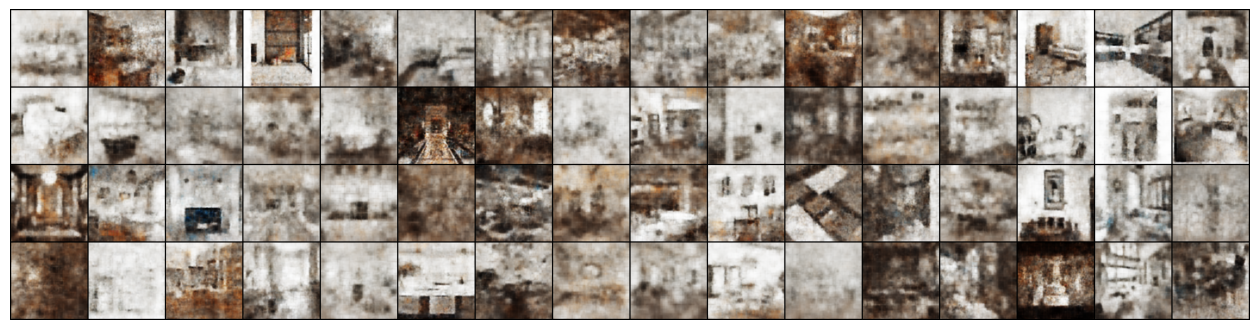

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the trained model
model.load_state_dict(torch.load("vae_epoch_400.pth"))
model.eval()

# Test on some data
with torch.no_grad():
    for condition, image in dataloader:
        condition = condition.to(device)
        image = image.to(device)

        recon_image, _, _ = model(image, condition)

        # Show the reconstructed image
        grid = torchvision.utils.make_grid(recon_image.cpu(), nrow=16, normalize=True)

        # Convert tensor to numpy image
        np_grid = grid.numpy().transpose((1, 2, 0))

        # Display the image
        plt.figure(figsize=(16, 16))
        plt.axis('off')
        plt.imshow(np_grid)
        plt.show()
        break


### Original vs. Reconstructed Images (Train Data)

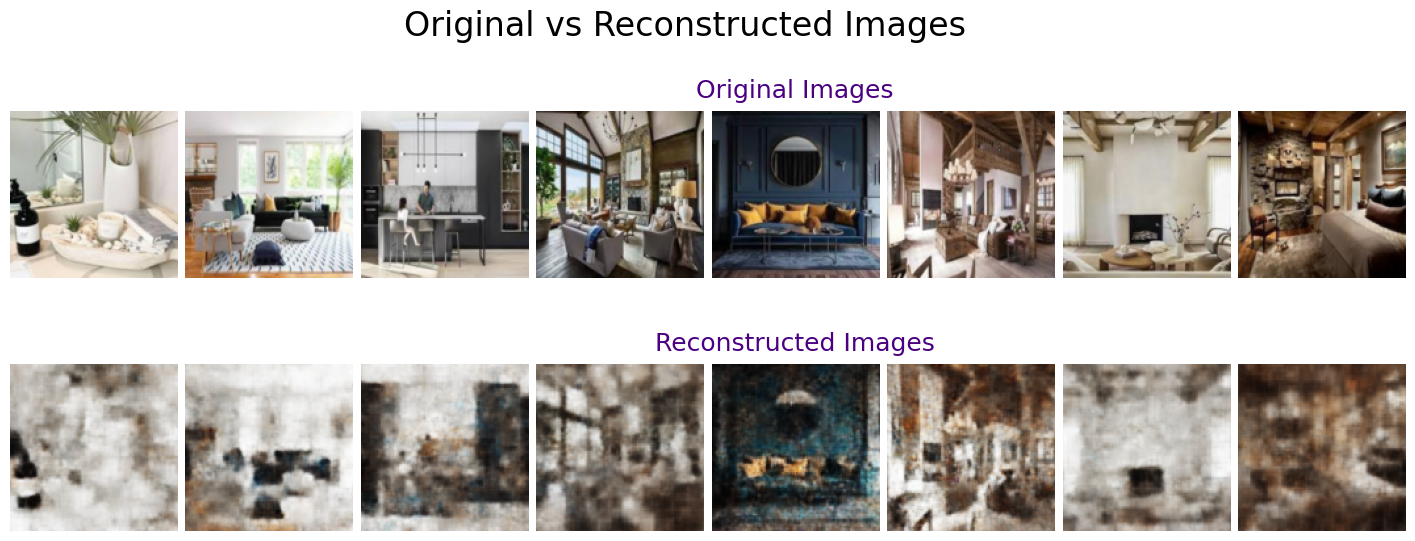

In [33]:
model.load_state_dict(torch.load("vae_epoch_400.pth"))
learning_rate = 1e-4
beta = 0.01  # KLD loss weight
model.eval()

with torch.no_grad():
    for condition, image in dataloader:
        condition = condition.to(device)
        image = image.to(device)

        recon_image, mu, logvar = model(image, condition)
        loss, recon_loss, kld_loss = model.loss_function(recon_image, image, mu, logvar, beta)

        num_images = 8
        original_images = image[:num_images].cpu()
        reconstructed_images = recon_image[:num_images].cpu()

        fig, axes = plt.subplots(2, num_images, figsize=(18, 7), gridspec_kw={'height_ratios': [1, 1]})
        fig.suptitle('Original vs Reconstructed Images', fontsize=24, color='black', y=0.9)

        for i in range(num_images):
            # Original images
            axes[0, i].imshow(original_images[i].permute(1, 2, 0))
            axes[0, i].axis('off')

            # Reconstructed images
            axes[1, i].imshow(reconstructed_images[i].permute(1, 2, 0))
            axes[1, i].axis('off')

        # Titles for the two rows
        axes[0, num_images // 2].set_title('Original Images', fontsize=18, color='indigo', pad=10)
        axes[1, num_images // 2].set_title('Reconstructed Images', fontsize=18, color='indigo', pad=10)

        # Adjust layout to reduce excess space
        plt.subplots_adjust(wspace=0.05, hspace=0.1, top=0.8)
        plt.show()
        break


## Evaluation

## Submitting to the online challenge: ramp.studio
Once you found a good model, you can submit it to ramp.studio to enter the online challenge. First, if it is your first time using the RAMP platform, sign up, otherwise log in. Then sign up to the specific event for the data challenge. Both signups are controled by RAMP administrators, so there can be a delay between asking for signup and being able to submit.

Once your signup request is accepted, you can go to your sandbox and write the code for your generator directly on the browser. You can also create a new folder my_submission in the submissions folder containing CondImageGenerator.py and upload this file directly. You can check the starting-kit (CondImageGenerator.py) for an example. The submission is trained and tested on our backend in the similar way as ramp-test does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in my submissions. Once it is trained, your submission shows up on the public leaderboard. If there is an error (despite having tested your submission locally with ramp-test), it will show up in the "Failed submissions" table in my submissions. You can click on the error to see part of the trace.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, etc., locally, and checking them with ramp-test. The script prints mean cross-validation scores.

Here is the script proposed as the starting_kit:

In [37]:
# Conditional VAE Class
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm


class Encoder(nn.Module):
    def _init_(self, input_channels, hidden_dim, latent_dim, n_layers, condition_dim=768, dropout=0.3, new_dim=768, device='cuda'):
        super(Encoder, self)._init_()
        self.dropout = 0.1
        self.device = device
        self.input_channels = input_channels
        self.latent_dim = latent_dim
        self.condition_dim = condition_dim
        self.hidden_dim = hidden_dim
        self.new_dim = new_dim
        # MLP to process conditioning information
        self.mlp = nn.Sequential(
            nn.Linear(self.condition_dim, self.new_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(self.new_dim, self.new_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(self.new_dim, self.new_dim),
            nn.LeakyReLU(0.2)
        ).to(self.device)

        # Convolutional layers for image encoding
        self.convs = nn.ModuleList([
            nn.Conv2d(self.input_channels, self.hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.Conv2d(self.hidden_dim, self.hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.Conv2d(self.hidden_dim, self.hidden_dim, kernel_size=4, stride=2, padding=1)
        ]).to(self.device)
        
        self.global_pool = nn.AdaptiveAvgPool2d(1).to(self.device)
        self.bn = nn.BatchNorm1d(hidden_dim + self.new_dim).to(self.device)
        self.fc = nn.Linear(self.hidden_dim + self.new_dim, self.latent_dim).to(self.device)

    def forward(self, x, cond):
        x = x.to(self.device)
        cond = cond.to(self.device)
        
        # Process the conditioning information
        cond_feats = self.mlp(cond)
        cond_feats = cond_feats.to(device=self.device)

        # Pass the image through the convolutional layers
        for conv in self.convs:
            x = F.leaky_relu(conv(x), 0.2)
            x = F.dropout(x, self.dropout, training=self.training)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the pooled output

        # Concatenate the conditioning features with the pooled image features
        x = torch.cat([x, cond_feats], dim=-1)

        # Batch normalization and projection to latent space
        x = self.bn(x)
        x = self.fc(x)

        return x


class Decoder(nn.Module):
    def _init_(self, latent_dim, hidden_dim, n_layers, output_channels, cond_dim=768, new_dim=768, device='cuda'):
        super(Decoder, self)._init_()
        self.n_layers = n_layers
        self.device = device
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.output_channels = output_channels
        self.cond_dim = cond_dim
        self.new_dim = new_dim
        self.n_layers = n_layers

        # MLP to process conditioning information
        self.mlpf = nn.Sequential(
            nn.Linear(self.cond_dim, self.new_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(self.new_dim, self.new_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(self.new_dim, self.new_dim),
            nn.LeakyReLU(0.2)
        ).to(self.device)

        # MLP layers to decode latent + condition into a feature map
        mlp_layers = [nn.Linear(self.latent_dim + self.new_dim, self.hidden_dim)]
        mlp_layers += [nn.Linear(self.hidden_dim, self.hidden_dim) for _ in range(self.n_layers - 2)]
        mlp_layers.append(nn.Linear(self.hidden_dim, 8 * 8 * self.hidden_dim))
        self.mlp = nn.ModuleList(mlp_layers).to(self.device)

        self.relu = nn.ReLU().to(self.device)

        # Transposed convolutional layers for upsampling
        self.deconvs = nn.Sequential(
            nn.ConvTranspose2d(self.hidden_dim, self.hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(self.hidden_dim, self.hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(self.hidden_dim, self.hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(self.hidden_dim, self.output_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        ).to(self.device)

    def forward(self, x, cond):
        x = x.to(self.device)
        cond = cond.to(self.device)

        cond = self.mlpf(cond)
        x = torch.cat([x, cond], dim=-1)

        for i in range(self.n_layers - 1):
            x = self.relu(self.mlp[i](x))
        x = self.mlp[self.n_layers - 1](x)

        x = x.view(x.size(0), -1, 8, 8)
        x = self.deconvs(x)
        return x


class ConditionalVAE(nn.Module):
    def _init_(self, input_channels=3, hidden_dim_enc=128, hidden_dim_dec=128,
                 latent_dim=128, n_layers_enc=4, n_layers_dec=4,
                 condition_dim=768, image_size=128, cond_new_dim=768, device='cuda'):
        super(ConditionalVAE, self)._init_()
        self.device = device
        self.latent_dim = latent_dim
        self.input_channels = input_channels
        self.condition_dim = condition_dim
        self.image_size = image_size
        self.cond_new_dim = cond_new_dim
        self.hidden_dim_enc = hidden_dim_enc
        self.hidden_dim_dec = hidden_dim_dec
        self.n_layers_enc = n_layers_enc
        self.n_layers_dec = n_layers_dec
        self.encoder = Encoder(input_channels=self.input_channels, hidden_dim=self.hidden_dim_enc, latent_dim=self.latent_dim, n_layers=self.n_layers_enc, condition_dim=self.condition_dim, new_dim=self.cond_new_dim, device=self.device)
        self.decoder = Decoder(latent_dim=self.latent_dim, hidden_dim=self.hidden_dim_dec, n_layers=self.n_layers_dec, output_channels=self.input_channels, cond_dim=self.condition_dim, new_dim=self.cond_new_dim, device=self.device)

        self.fc_mu = nn.Linear(self.latent_dim, self.latent_dim).to(self.device)
        self.fc_logvar = nn.Linear(self.latent_dim, self.latent_dim).to(self.device)

    def encode(self, x, c):
        x, c = x.to(self.device), c.to(self.device)
        x_g = self.encoder(x, c)
        mu = self.fc_mu(x_g)
        logvar = self.fc_logvar(x_g)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std).to(self.device)
            return mu + eps * std
        return mu

    def decode(self, z, c):
        return self.decoder(z.to(self.device), c.to(self.device))

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar

    def loss_function(self, recon_x, x, mu, logvar, beta=0.01):
        # Compute reconstruction and KL-divergence loss
        recon_loss = F.mse_loss(recon_x, x, reduction='mean')
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + beta * kld_loss
        return loss, recon_loss, kld_loss
    
    def fit(self, dataloader):
      epochs = 1
      learning_rate = 1e-4
      beta = 0.01  # KLD loss weight

      optimizer = optim.Adam(self.parameters(), lr=learning_rate)

      # Training loop
      for epoch in range(epochs):
          self.train()
          running_loss = 0.0

          for i, (condition, image) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
              condition = condition.to(self.device)  # Text embeddings
              image = image.to(self.device)          # Image tensor
              optimizer.zero_grad()

              # Forward pass
              recon_image, mu, logvar = self.forward(image, condition)

              # Compute the loss
              loss, recon_loss, kld_loss = self.loss_function(recon_image, image, mu, logvar, beta)

              # Backpropagation
              loss.backward()
              optimizer.step()

              running_loss += loss.item()

          avg_loss = running_loss / len(dataloader)
          print(f"Loss: {avg_loss:.4f}")
          # Save the model after every epoch
          torch.save(self.state_dict(), f"vae_epoch_{epoch+1}.pth")

    @torch.no_grad()
    def predict(self, dataloader):
        self.eval()
        res = []
        for condition, _ in tqdm(dataloader):
            condition = condition.to(self.device)
            n = len(condition)
            samples = torch.randn((n, self.latent_dim), device=self.device)
            decoded_samples = self.decode(samples, condition)
            res.append(decoded_samples.cpu().numpy())
        return np.concatenate(res)

In [ ]:
!ramp-test --submission starting_kit --quick-test